# Project
## download data
- https://ieee-dataport.org/open-access/data-server-energy-consumption-dataset

## Preprocess data


In [ ]:
import os
import pandas as pd

# Set the path to the data folder
data_folder = "/workspaces/visualization-energy/data"


# Get the list of CSV files in the data folder
csv_files = [file for file in os.listdir(data_folder) if file.endswith(".csv")]

# Iterate over each CSV file
for ind, file in enumerate(csv_files):
    # Read the CSV file
    file_path = os.path.join(data_folder, file)
    iterator = pd.read_csv(
        file_path,
        sep=",",
        engine="python",
        encoding="utf-8",
        on_bad_lines="skip",
        chunksize=100_000,
    )
    i = 0
    while True:
        try:
            chunk = next(iterator)
            chunk.to_parquet(
                os.path.join(data_folder, "processed_data", f"datacenter_{ind}_{i}_.parquet"),
                index=False,
                #encoding="utf-8",
            )
        except Exception as e:
            print(f"Error reading file {file} {i}: {e} ")
            i += 1
            break
        i += 1

### Here's a summary of how the code works:

The code starts by importing the necessary libraries, including os for file operations and pandas for data manipulation.

It sets the path to the data folder where the CSV files are located. In this case, the path is "/workspaces/visualization-energy/data".

It retrieves a list of CSV files in the data folder using a list comprehension and the os.listdir() function. The condition file.endswith(".csv") ensures that only files with the ".csv" extension are included in the list.

The code then iterates over each CSV file using a for loop and the enumerate() function to get both the index and the file name.

Inside the loop, it reads the CSV file using the pd.read_csv() function. Several parameters are provided to handle potential issues with the dataset:

sep specifies the delimiter used in the CSV file (in this case, a comma).
engine specifies the parsing engine to use (in this case, "python").
encoding specifies the character encoding of the file (in this case, "utf-8").
on_bad_lines specifies the action to take when encountering bad lines in the file (in this case, "skip").
chunksize specifies the number of rows to read at a time (in this case, 100,000).
The code then enters a while loop to process each chunk of data read from the CSV file. It uses a try-except block to handle any exceptions that may occur during the processing.

Inside the try block, it retrieves the next chunk of data using the next() function on the iterator object. It then saves the chunk as a Parquet file using the to_parquet() function. The Parquet file is saved in the "processed_data" folder with a file name that includes the index and iteration numbers.

If an exception occurs during the processing of a chunk, the code enters the except block. It prints an error message indicating the file name and the iteration number where the error occurred. The i variable is incremented to move to the next iteration.

The while loop continues until all chunks of data have been processed.

Overall, this code handles reading a somewhat corrupted and Spanish CSV dataset by skipping bad lines, reading the data in chunks, and saving the processed data as Parquet files.

# Start of analysis
## import reqs

In [1]:
import pandas as pd 
import os
import glob
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

In [2]:

# Find all Parquet files starting with "datacenter"
# file_paths = glob.glob("datacenter*.parquet")
files = [f for f in os.listdir("/workspaces/visualization-energy/data/processed_data") if f.startswith("datacenter")]
print(files)
# Function to read a Parquet file and return a DataFrame
def read_parquet(file_path):
    return pd.read_parquet(file_path)

# Read Parquet files in parallel using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Submit tasks to read Parquet files
    futures = [executor.submit(read_parquet, os.path.join("/workspaces/visualization-energy/data/processed_data", file_path)) for file_path in files]

    # Wait for all tasks to complete and get the results
    dfs = [future.result() for future in futures]

# Join the DataFrames into one dataset
df = pd.concat(dfs)

# Print the joined dataset
print(df)


['datacenter_1_68_.parquet', 'datacenter_0_9_.parquet', 'datacenter_0_22_.parquet', 'datacenter_1_71_.parquet', 'datacenter_1_53_.parquet', 'datacenter_1_55_.parquet', 'datacenter_1_52_.parquet', 'datacenter_1_50_.parquet', 'datacenter_1_16_.parquet', 'datacenter_1_2_.parquet', 'datacenter_1_13_.parquet', 'datacenter_1_24_.parquet', 'datacenter_1_69_.parquet', 'datacenter_1_10_.parquet', 'datacenter_0_3_.parquet', 'datacenter_0_23_.parquet', 'datacenter_1_32_.parquet', 'datacenter_0_14_.parquet', 'datacenter_1_34_.parquet', 'datacenter_1_4_.parquet', 'datacenter_1_19_.parquet', 'datacenter_1_38_.parquet', 'datacenter_0_28_.parquet', 'datacenter_1_28_.parquet', 'datacenter_1_23_.parquet', 'datacenter_1_35_.parquet', 'datacenter_0_2_.parquet', 'datacenter_0_8_.parquet', 'datacenter_1_48_.parquet', 'datacenter_1_17_.parquet', 'datacenter_1_61_.parquet', 'datacenter_1_45_.parquet', 'datacenter_1_0_.parquet', 'datacenter_0_30_.parquet', 'datacenter_1_31_.parquet', 'datacenter_0_16_.parquet'

## Collected data - further processing of dtypes

In [3]:
df.fecha_servidor = pd.to_datetime(df.fecha_servidor)
df.fecha_esp32 = pd.to_datetime(df.fecha_esp32)

In [5]:
df.columns

Index(['MAC', 'weekday', 'fecha_servidor', 'fecha_esp32', 'voltaje',
       'corriente', 'potencia', 'frecuencia', 'energia', 'fp', 'ESP32_temp',
       'WORKSTATION_CPU', 'WORKSTATION_CPU_POWER', 'WORKSTATION_CPU_TEMP',
       'WORKSTATION_GPU', 'WORKSTATION_GPU_POWER', 'WORKSTATION_GPU_TEMP',
       'WORKSTATION_RAM', 'WORKSTATION_RAM_POWER'],
      dtype='object')

In [6]:
df.dtypes

MAC                              object
weekday                           int64
fecha_servidor           datetime64[ns]
fecha_esp32              datetime64[ns]
voltaje                         float64
corriente                       float64
potencia                        float64
frecuencia                      float64
energia                         float64
fp                              float64
ESP32_temp                      float64
WORKSTATION_CPU                 float64
WORKSTATION_CPU_POWER           float64
WORKSTATION_CPU_TEMP              int64
WORKSTATION_GPU                 float64
WORKSTATION_GPU_POWER             int64
WORKSTATION_GPU_TEMP            float64
WORKSTATION_RAM                 float64
WORKSTATION_RAM_POWER           float64
dtype: object

I am happy with the dtypes, renaming and saving to file.

In [7]:
translation_dict = {
    'MAC': 'Device MAC',
    'weekday': 'Weekday',
    'fecha_servidor': 'Server Date',
    'fecha_esp32': 'ESP32 Date',
    'voltaje': 'Voltage',
    'corriente': 'Current',
    'potencia': 'Power',
    'frecuencia': 'Frequency',
    'energia': 'Energy',
    'fp': 'Power Factor',
    'ESP32_temp': 'ESP32 Temperature',
    'WORKSTATION_CPU': 'Workstation CPU',
    'WORKSTATION_CPU_POWER': 'Workstation CPU Power',
    'WORKSTATION_CPU_TEMP': 'Workstation CPU Temperature',
    'WORKSTATION_GPU': 'Workstation GPU',
    'WORKSTATION_GPU_POWER': 'Workstation GPU Power',
    'WORKSTATION_GPU_TEMP': 'Workstation GPU Temperature',
    'WORKSTATION_RAM': 'Workstation RAM',
    'WORKSTATION_RAM_POWER': 'Workstation RAM Power'
}

# Rename the columns using the translation dictionary
df.columns = [translation_dict.get(col, col) for col in df.columns]

# Print the updated column names
print(df.columns)

Index(['Device MAC', 'Weekday', 'Server Date', 'ESP32 Date', 'Voltage',
       'Current', 'Power', 'Frequency', 'Energy', 'Power Factor',
       'ESP32 Temperature', 'Workstation CPU', 'Workstation CPU Power',
       'Workstation CPU Temperature', 'Workstation GPU',
       'Workstation GPU Power', 'Workstation GPU Temperature',
       'Workstation RAM', 'Workstation RAM Power'],
      dtype='object')


In [8]:
df.to_parquet("/workspaces/visualization-energy/data/datacenter_processed.parquet")

### Checkpoint - Further development and analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("/workspaces/visualization-energy/data/datacenter_processed.parquet")

In [3]:
df.columns, df.dtypes


(Index(['Device MAC', 'Weekday', 'Server Date', 'ESP32 Date', 'Voltage',
        'Current', 'Power', 'Frequency', 'Energy', 'Power Factor',
        'ESP32 Temperature', 'Workstation CPU', 'Workstation CPU Power',
        'Workstation CPU Temperature', 'Workstation GPU',
        'Workstation GPU Power', 'Workstation GPU Temperature',
        'Workstation RAM', 'Workstation RAM Power'],
       dtype='object'),
 Device MAC                             object
 Weekday                                 int64
 Server Date                    datetime64[ns]
 ESP32 Date                     datetime64[ns]
 Voltage                               float64
 Current                               float64
 Power                                 float64
 Frequency                             float64
 Energy                                float64
 Power Factor                          float64
 ESP32 Temperature                     float64
 Workstation CPU                       float64
 Workstation CPU Power  

In [4]:
import seaborn as sns

import matplotlib.pyplot as plt
# Convert the data to a timeseries indexed by the Server Date
df = df.set_index('Server Date')
# Aggregate the timeseries data per hour
# Dropping MAC address as it is not useful for the analysis and it is not a numerical value
df_hourly = df.drop(columns="Device MAC").resample('h').mean()

# Plot Active Energy over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hourly, x='Server Date', y='Energy')
plt.xlabel('Time')
plt.ylabel('Active Energy (KWh)')
plt.title('Active Energy over Time')
plt.savefig('active_energy.png')
plt.close()

# Plot ESP32 Temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hourly, x='Server Date', y='ESP32 Temperature')
plt.xlabel('Time')
plt.ylabel('ESP32 Temperature (°C)')
plt.title('ESP32 Temperature over Time')
plt.savefig('esp32_temperature.png')
plt.close()


compare it with external data on weather from: \n
https://open-meteo.com/en/docs/historical-weather-api#latitude=-2.1962&longitude=-79.8862&start_date=2021-04-01&end_date=2022-01-01&hourly=temperature_2m,relative_humidity_2m&daily=temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum

https://open-meteo.com/en/docs/historical-weather-api#start_date=2021-04-01&end_date=2022-01-01&hourly=temperature_2m,relative_humidity_2m,rain,cloud_cover,wind_speed_10m 



In [5]:
# Code generated from open-meteo.com
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -2.1962,
	"longitude": -79.8862,
	"start_date": "2021-04-01",
	"end_date": "2022-01-01",
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "cloud_cover", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates -2.2144112586975098°N -79.872314453125°E
Elevation 10.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  temperature_2m  relative_humidity_2m  rain  \
0    2021-04-01 00:00:00+00:00       26.989000             77.594978   0.0   
1    2021-04-01 01:00:00+00:00       26.389000             79.656860   0.0   
2    2021-04-01 02:00:00+00:00       26.088999             82.569710   0.0   
3    2021-04-01 03:00:00+00:00       25.789000             82.534180   0.0   
4    2021-04-01 04:00:00+00:00       25.438999             80.259972   0.0   
...                        ...             ...                   ...   ...   
6619 2022-01-01 19:00:00+00:00       27.838999             63.350498   0.0   
6620 2022-01-01 20:00:00+00:00       28.188999             62.070850   0.0   
6621 2022-01-01 21:00:00+00:00       28.438999             61.174648   0.0   
6622 2022-01-01 22:00:00+00:00       28.188999             63.231007   0.0   
6623 2022-01-01 

In [6]:
df_hourly

,Weekday,ESP32 Date,Voltage,Current,Power,Frequency,Energy,Power Factor,ESP32 Temperature,Workstation CPU,Workstation CPU Power,Workstation CPU Temperature,Workstation GPU,Workstation GPU Power,Workstation GPU Temperature,Workstation RAM,Workstation RAM Power
Server Date,,,,,,,,,,,,,,,,,
2021-05-05 22:00:00,3.0,2021-05-05 22:36:52.149180160,120.034499,0.941585,97.385655,59.959178,0.051828,0.861537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-05 23:00:00,3.0,2021-05-05 23:29:41.669532416,120.024208,0.950836,98.685173,59.958220,0.138101,0.864397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-06 00:00:00,4.0,2021-05-06 00:30:20.059895808,120.030852,0.934580,96.581265,59.970542,0.236383,0.860619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-06 01:00:00,4.0,2021-05-06 01:29:56.708513536,120.030297,0.936262,96.660608,59.961011,0.332502,0.860407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-06 02:00:00,4.0,2021-05-06 02:30:12.611871488,120.025007,0.937655,96.976703,59.964326,0.429985,0.861198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 17:00:00,5.0,2021-12-03 17:29:59.500000000,119.216972,0.887801,98.062903,59.955236,232.320059,0.932976,51.370882,6.458806,36.338353,27.789444,0.002917,32.793056,7.082914,33.952317,7.724896
2021-12-03 18:00:00,5.0,2021-12-03 18:29:59.500000000,119.235944,0.865304,95.115750,59.960569,232.415601,0.929056,51.103058,5.096478,36.332369,25.874167,0.002500,33.132083,7.085172,34.157283,7.159331
2021-12-03 19:00:00,5.0,2021-12-03 19:29:59.250034688,119.226781,0.888132,98.058341,59.961314,232.484155,0.932723,51.243276,6.467054,36.373496,27.659675,0.002639,33.501736,7.079831,34.362614,7.853566


In [13]:
# Convert the index of df_hourly to a tz-aware DatetimeIndex
df_hourly.index = df_hourly.index.tz_localize('UTC')

# Join the df_hourly and hourly_dataframe dataframes using pd.concat
merged_df = pd.merge(df_hourly, hourly_dataframe, left_index=True, right_on='date', how='inner')
#pd.concat([df_hourly, hourly_dataframe.set_index('date')], axis=1)

# Print the merged dataframe
print(merged_df)


      Weekday                    ESP32 Date     Voltage   Current      Power  \
838       3.0 2021-05-05 22:36:52.149180160  120.034499  0.941585  97.385655   
839       3.0 2021-05-05 23:29:41.669532416  120.024208  0.950836  98.685173   
840       4.0 2021-05-06 00:30:20.059895808  120.030852  0.934580  96.581265   
841       4.0 2021-05-06 01:29:56.708513536  120.030297  0.936262  96.660608   
842       4.0 2021-05-06 02:30:12.611871488  120.025007  0.937655  96.976703   
...       ...                           ...         ...       ...        ...   
5921      5.0 2021-12-03 17:29:59.500000000  119.216972  0.887801  98.062903   
5922      5.0 2021-12-03 18:29:59.500000000  119.235944  0.865304  95.115750   
5923      5.0 2021-12-03 19:29:59.250034688  119.226781  0.888132  98.058341   
5924      5.0 2021-12-03 20:29:59.000000000  119.234514  0.866392  95.241444   
5925      5.0 2021-12-03 21:13:44.500000000  119.236372  0.865732  95.132950   

      Frequency      Energy  Power Fact

In [17]:
merged_df

,Weekday,ESP32 Date,Voltage,Current,Power,Frequency,Energy,Power Factor,ESP32 Temperature,Workstation CPU,...,Workstation GPU Power,Workstation GPU Temperature,Workstation RAM,Workstation RAM Power,date,temperature_2m,relative_humidity_2m,rain,cloud_cover,wind_speed_10m
838,3.0,2021-05-05 22:36:52.149180160,120.034499,0.941585,97.385655,59.959178,0.051828,0.861537,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2021-05-05 22:00:00+00:00,27.389000,80.032387,0.0,36.299999,13.905509
839,3.0,2021-05-05 23:29:41.669532416,120.024208,0.950836,98.685173,59.958220,0.138101,0.864397,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2021-05-05 23:00:00+00:00,25.588999,84.282761,0.0,55.799999,15.141414
840,4.0,2021-05-06 00:30:20.059895808,120.030852,0.934580,96.581265,59.970542,0.236383,0.860619,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2021-05-06 00:00:00+00:00,25.438999,84.266563,0.0,55.200001,13.684735
841,4.0,2021-05-06 01:29:56.708513536,120.030297,0.936262,96.660608,59.961011,0.332502,0.860407,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2021-05-06 01:00:00+00:00,24.838999,84.458649,0.0,100.000000,10.383987
842,4.0,2021-05-06 02:30:12.611871488,120.025007,0.937655,96.976703,59.964326,0.429985,0.861198,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2021-05-06 02:00:00+00:00,24.539000,84.684746,0.0,100.000000,12.261157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5921,5.0,2021-12-03 17:29:59.500000000,119.216972,0.887801,98.062903,59.955236,232.320059,0.932976,51.370882,6.458806,...,32.793056,7.082914,33.952317,7.724896,2021-12-03 17:00:00+00:00,28.489000,58.771893,0.0,5.400000,6.618519
5922,5.0,2021-12-03 18:29:59.500000000,119.235944,0.865304,95.115750,59.960569,232.415601,0.929056,51.103058,5.096478,...,33.132083,7.085172,34.157283,7.159331,2021-12-03 18:00:00+00:00,29.838999,53.855240,0.0,2.100000,3.617955
5923,5.0,2021-12-03 19:29:59.250034688,119.226781,0.888132,98.058341,59.961314,232.484155,0.932723,51.243276,6.467054,...,33.501736,7.079831,34.362614,7.853566,2021-12-03 19:00:00+00:00,30.588999,51.747711,0.0,7.800000,10.661107
5924,5.0,2021-12-03 20:29:59.000000000,119.234514,0.866392,95.241444,59.959986,232.666791,0.929026,50.769338,5.134268,...,33.481528,7.077276,34.648513,7.034401,2021-12-03 20:00:00+00:00,28.989000,59.621010,0.0,12.900000,20.617661


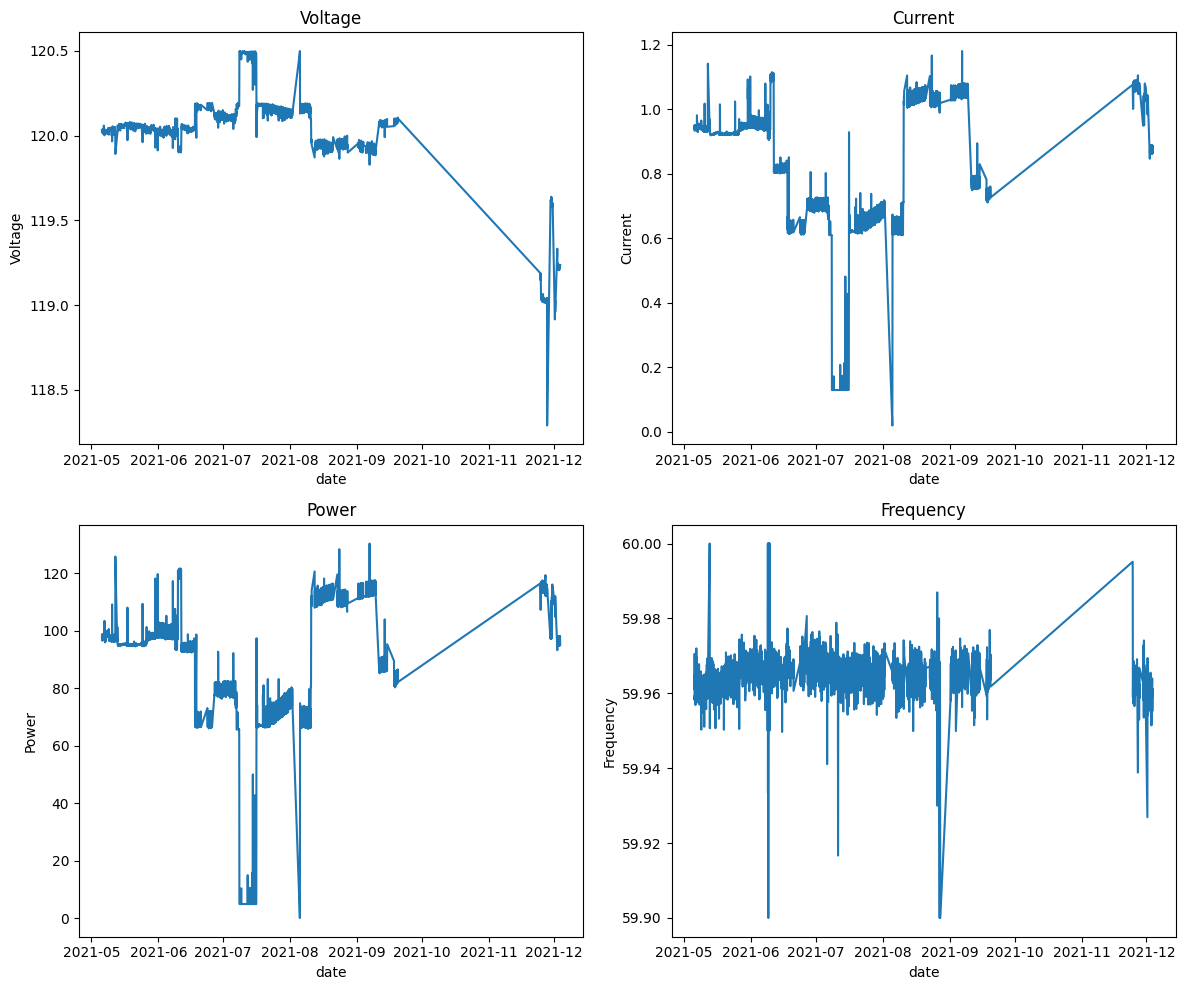

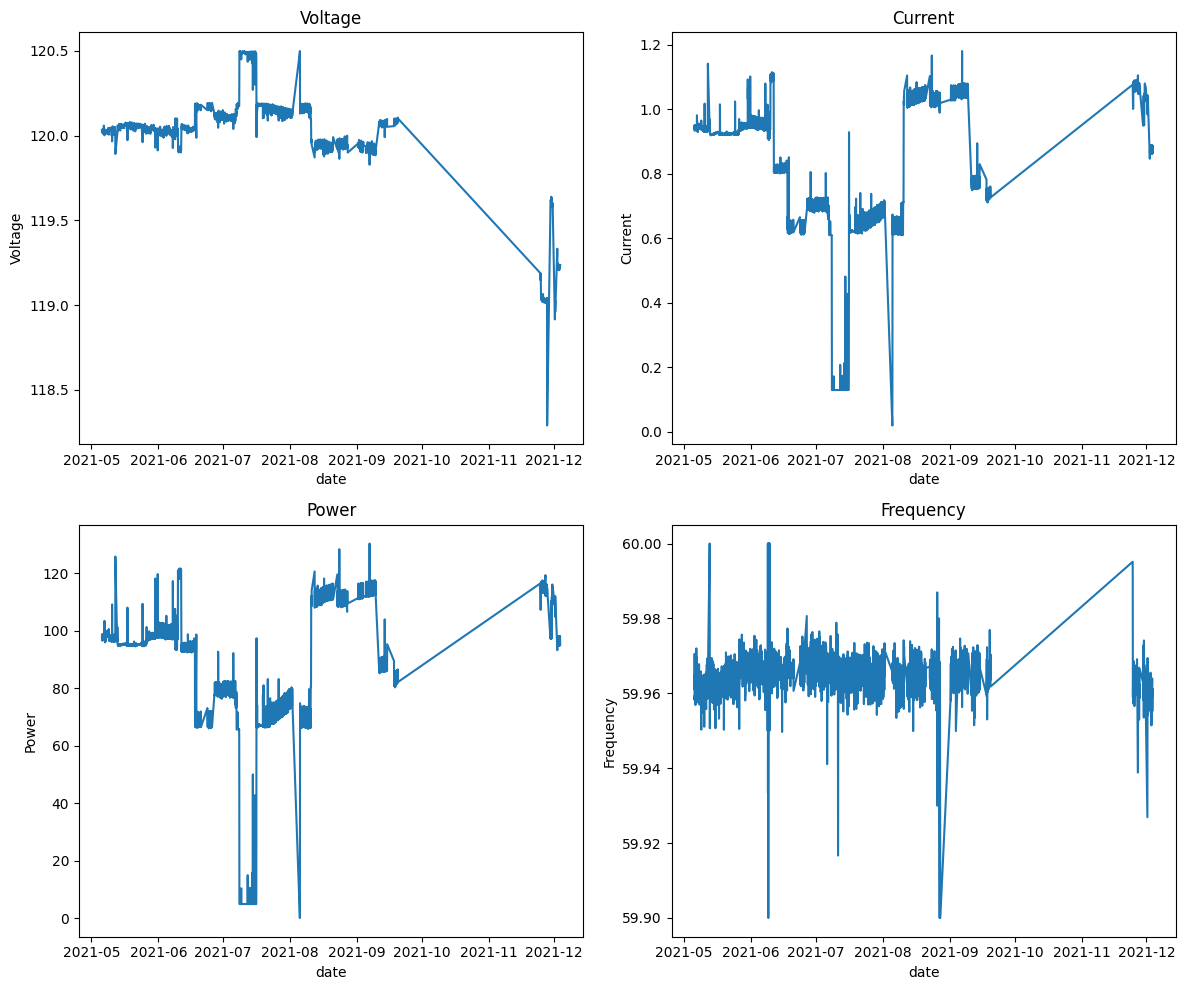

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns for the plots
columns = ['Voltage', 'Current', 'Power', 'Frequency', 'Energy', 'Power Factor', 'ESP32 Temperature',
           'Workstation CPU', 'Workstation CPU Power', 'Workstation CPU Temperature', 'Workstation GPU',
           'Workstation GPU Power', 'Workstation GPU Temperature', 'Workstation RAM', 'Workstation RAM Power',
internal_temparature = []
           
weather = ['temperature_2m', 'relative_humidity_2m', 'rain', 'cloud_cover', 'wind_speed_10m']

# Set the X-axis as 'date'
x_axis = 'date'

# Set the number of subplots and their arrangement
num_plots = 4
num_cols = 2
num_rows = (num_plots + 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
axes = axes.flatten()

# Iterate over the columns and create line plots
for i, column in enumerate(columns[:num_plots]):
    # Select the data for the column
    data = merged_df[[x_axis, column]]
    
    # Plot the line plot
    sns.lineplot(data=data, x=x_axis, y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(x_axis)
    axes[i].set_ylabel(column)

# Remove any extra subplots
if num_plots < len(axes):
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

# Adjust the layout and spacing
fig.tight_layout()

# Show the plot
plt.show()


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns for each category
machine_values = ['Voltage', 'Current', 'Power', 'Frequency', 'Energy', 'Power Factor', 'ESP32 Temperature', 'Power']
internal_values = ['Workstation CPU', 'Workstation CPU Power', 'Workstation CPU Temperature', 'Workstation GPU',
                   'Workstation GPU Power', 'Workstation GPU Temperature', 'Workstation RAM', 'Workstation RAM Power']
weather_values = ['temperature_2m', 'relative_humidity_2m', 'rain', 'cloud_cover', 'temperature_2m', 'wind_speed_10m', 'temperature_2m', 'temperature_2m']

# Set the X-axis as 'date'
x_axis = 'date'

# Set the number of subplots and their arrangement
num_plots = 8
num_cols = 2
num_rows = (num_plots + 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15))
axes = axes.flatten()
# Decrease the size of legend text
# Iterate over the columns and create line plots
for i, (machine_col, internal_col, weather_col) in enumerate(zip(machine_values, internal_values, weather_values)):
    # Select the data for the columns
    data = merged_df[[x_axis, machine_col, internal_col, weather_col]]
    
    # Plot the line plot
    sns.lineplot(data=data, x=x_axis, y=machine_col, ax=axes[i], label=machine_col)
    sns.lineplot(data=data, x=x_axis, y=internal_col, ax=axes[i], label=internal_col)
    sns.lineplot(data=data, x=x_axis, y=weather_col, ax=axes[i], label=weather_col)

    axes[i].set_title(f'Comparison of {machine_col}, {internal_col}, and {weather_col}')
    axes[i].set_xlabel(x_axis)
    axes[i].set_ylabel('Value')
    axes[i].legend()

# Remove any extra subplots
if num_plots < len(axes):
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

# Adjust the layout and spacing
fig.tight_layout()

# Save the plots with appropriate names
plt.savefig('comparison_plot_1.png')
plt.close()


<Axes: xlabel='Server Date'>

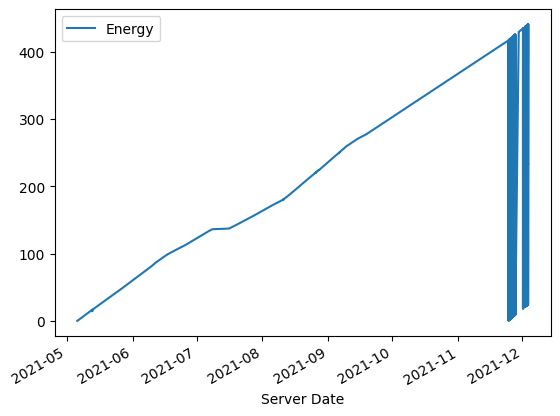

In [19]:
df.groupby("Server Date").agg({"Energy": "mean"}).plot()

In [10]:
df

,Device MAC,Weekday,ESP32 Date,Voltage,Current,Power,Frequency,Energy,Power Factor,ESP32 Temperature,Workstation CPU,Workstation CPU Power,Workstation CPU Temperature,Workstation GPU,Workstation GPU Power,Workstation GPU Temperature,Workstation RAM,Workstation RAM Power
Server Date,,,,,,,,,,,,,,,,,,
2021-07-19 09:12:11,3C:61:05:12:96:30,1,2021-07-19 09:12:11,120.2,0.61,66.1,60.0,142.32,0.90,30.56,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2021-07-19 09:12:12,3C:61:05:12:96:30,1,2021-07-19 09:12:12,120.2,0.63,67.6,60.0,142.32,0.90,30.56,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2021-07-19 09:12:13,3C:61:05:12:96:30,1,2021-07-19 09:12:13,120.2,0.62,67.5,60.0,142.32,0.90,30.56,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2021-07-19 09:12:14,3C:61:05:12:96:30,1,2021-07-19 09:12:14,120.2,0.62,67.3,60.0,142.32,0.90,30.56,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2021-07-19 09:12:15,3C:61:05:12:96:30,1,2021-07-19 09:12:15,120.1,0.66,71.3,59.9,142.32,0.90,30.56,0.0,0.0,0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18 03:40:38,3C:61:05:12:96:30,7,2021-07-18 03:40:38,120.2,0.62,67.2,60.0,140.34,0.90,33.89,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2021-07-18 03:40:39,3C:61:05:12:96:30,7,2021-07-18 03:40:39,120.1,0.63,67.2,59.9,140.34,0.89,33.89,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2021-07-18 03:40:40,3C:61:05:12:96:30,7,2021-07-18 03:40:40,120.2,0.63,67.7,59.9,140.34,0.90,34.44,0.0,0.0,0,0.0,0,0.0,0.0,0.0


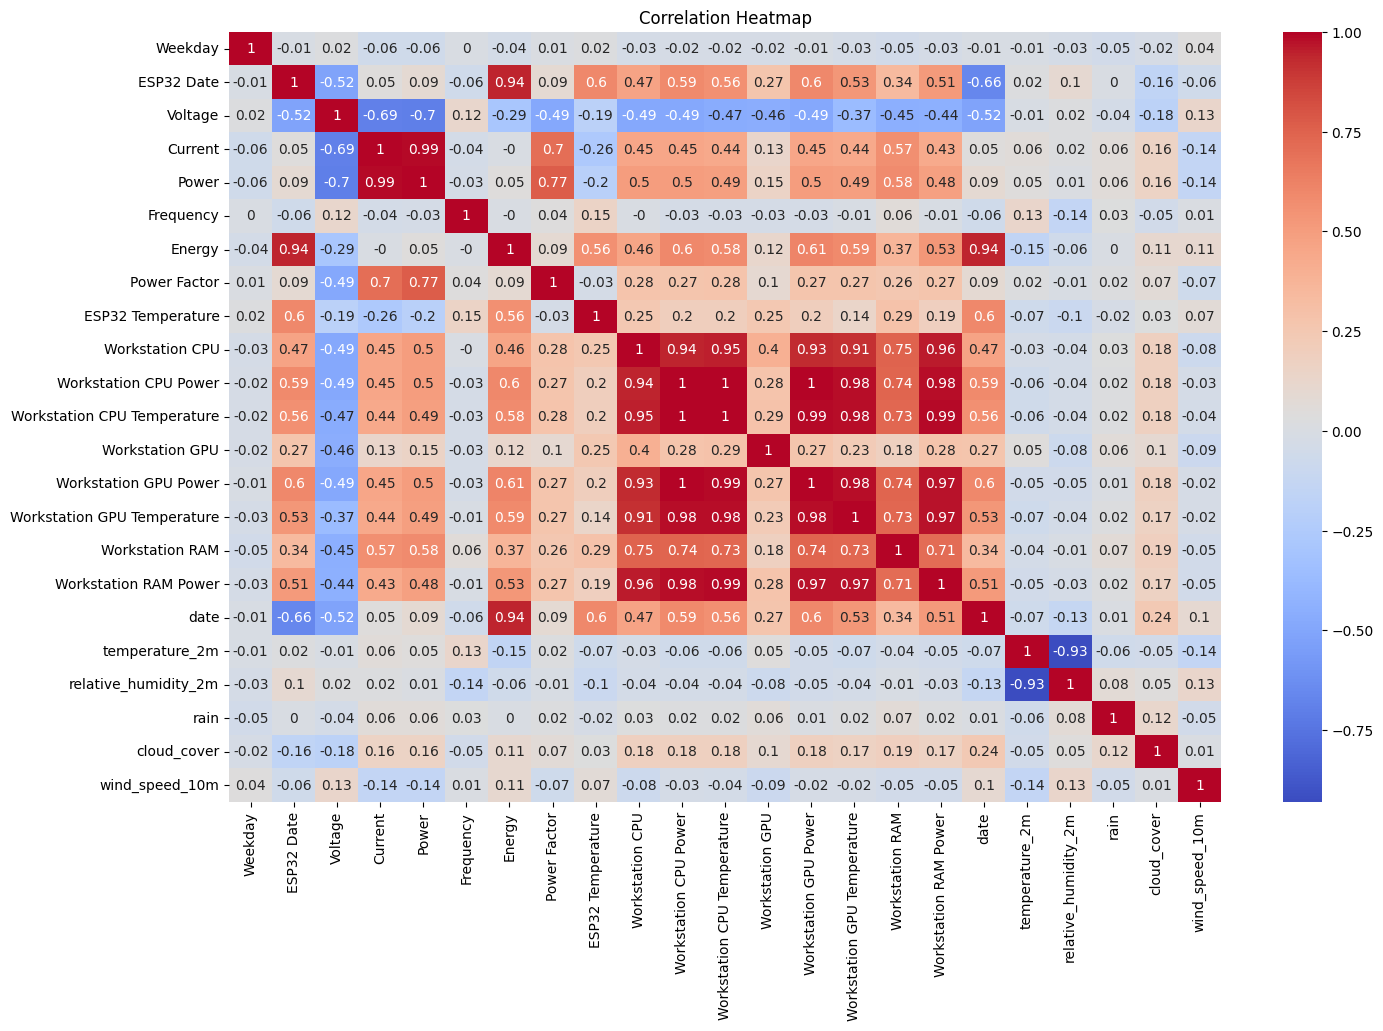

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt



# Calculate the correlation matrix
correlation_matrix = merged_df.corr()
# Round the numbers to 2 decimal places
correlation_matrix = correlation_matrix.round(2)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

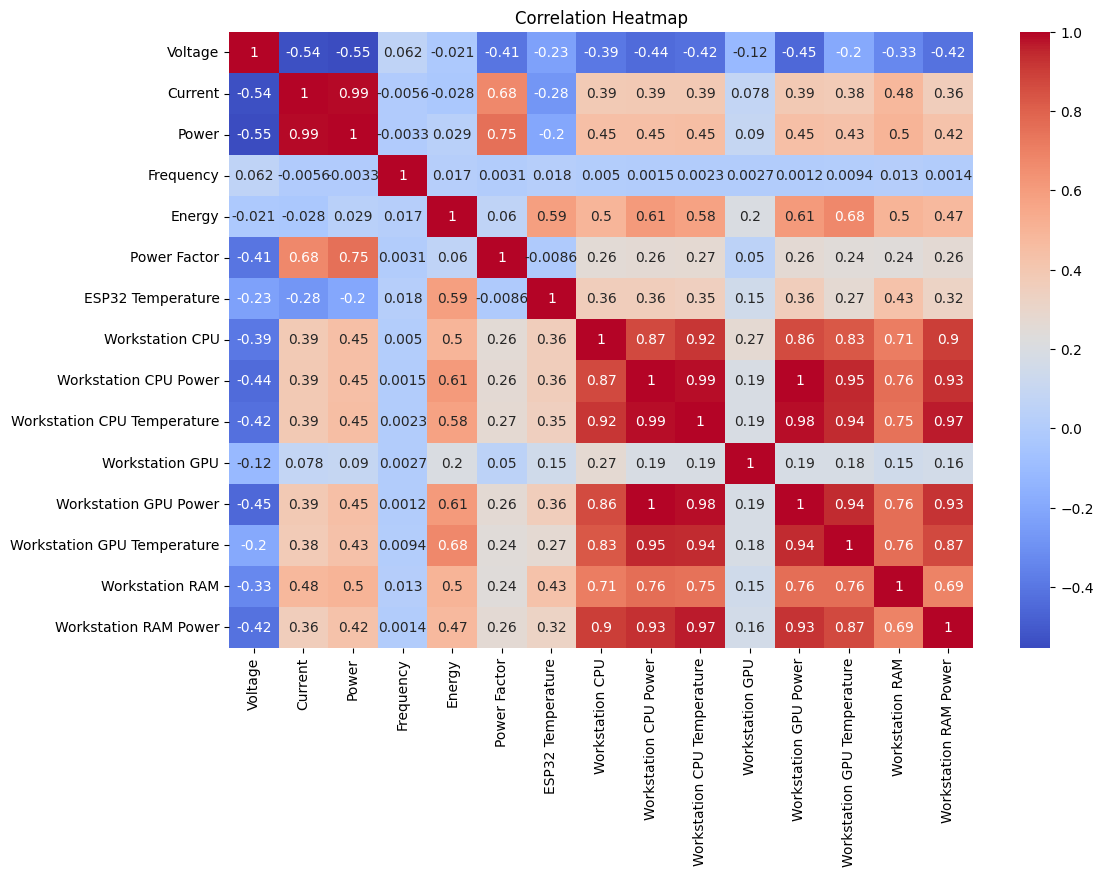

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns for correlation analysis
columns = ['Voltage', 'Current', 'Power', 'Frequency', 'Energy', 'Power Factor', 'ESP32 Temperature',
           'Workstation CPU', 'Workstation CPU Power', 'Workstation CPU Temperature', 'Workstation GPU',
           'Workstation GPU Power', 'Workstation GPU Temperature', 'Workstation RAM', 'Workstation RAM Power']
# Round the numbers to 2 decimal places
df[columns] = df[columns].round(2)
# Calculate the correlation matrix
correlation_matrix = df[columns].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# EDA Plan: Visualizing Energy Consumption Data of a Datacenter

## Introduction
Provide a brief introduction to the project and the purpose of the EDA.

## Data Description
Describe the energy consumption data of the datacenter, including the variables/columns available and their meanings.

## Data Cleaning and Preprocessing
Outline the steps taken to clean and preprocess the data, such as handling missing values, removing duplicates, and transforming variables if necessary.

## Exploratory Data Analysis
Perform exploratory data analysis to gain insights into the energy consumption data. Include the following visualizations:

### 1. Time Series Analysis
- Plot the energy consumption over time to identify any trends or patterns.
- Analyze the data for seasonality, cyclic patterns, or any other temporal characteristics.

### 2. Distribution Analysis
- Visualize the distribution of energy consumption values.
- Identify any outliers or anomalies in the data.

### 3. Correlation Analysis
- Explore the relationships between different variables.
- Calculate correlation coefficients and create correlation matrices.
- Visualize the correlations using heatmaps or scatter plots.

### 4. Aggregated Analysis
- Aggregate the energy consumption data by different dimensions, such as day of the week, hour of the day, or specific devices.
- Visualize the aggregated data to identify any patterns or trends.

### 5. Comparison Analysis
- Compare the energy consumption of different devices or areas within the datacenter.
- Use bar charts, box plots, or other appropriate visualizations to highlight the differences.

## Conclusion
Summarize the key findings from the EDA and any insights gained from the visualizations.

## Next Steps
Outline the next steps in the analysis, such as feature engineering, modeling, or further data exploration.
